# Contribution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import netCDF4
from global_land_mask import globe
import matplotlib as mpl
from scipy.optimize import curve_fit
import metpy.calc as mpcalc
from metpy.units import units
import scipy
import metpy
from sklearn.linear_model import LinearRegression
mpl.rcParams['figure.dpi']= 500

g = 9.80616
Cp = 1004.64
Lv = 2.501e6
R = 287

In [2]:
#model2 = '/media/rakshith/Seagate Expansion Drive/Good models/CMCC/*.nc'
#cmcc = xr.open_mfdataset(model2)

#model2 = '/media/rakshith/Seagate Expansion Drive/Good models/E3SM-1-0/*.nc'
#cmcc = xr.open_mfdataset(model2)

model2 = '/media/rakshith/Seagate Expansion Drive/Good models/INM-CM5-0/*.nc'
cmcc = xr.open_mfdataset(model2)

In [3]:
#grid1 = cmcc.sel(lat=slice(10,30), lon=slice(70,90))
grid1 = cmcc.sel(lat=slice(0,30))

months = grid1.time.dt.month.isin(range(6, 10))
JJAS = grid1.sel(time=months) 

l=[]
for i in grid1.lon:
    if i>180:
        l.append(i-360)
    else:
        l.append(i)
            
lon_grid, lat_grid = np.meshgrid(l, grid1.lat)
mask1 = globe.is_land(lat_grid, lon_grid)

In [4]:
clim=JJAS.resample(time="10AS").mean()

In [5]:
Pwat = clim.prw.where(mask1>0).mean(dim=['lat', 'lon'])
P = 86400*28.96*((clim.pr.where(mask1>0).mean(dim=['lat', 'lon'])-clim.evspsbl.where(mask1>0).mean(dim=['lat', 'lon'])))
Qdiv = clim.rsdt.where(mask1>0).mean(dim=['lat', 'lon']) - clim.rsut.where(mask1>0).mean(dim=['lat', 'lon']) - clim.rlut.where(mask1>0).mean(dim=['lat', 'lon'])
E = 86400*28.96*(clim.evspsbl.where(mask1>0).mean(dim=['lat', 'lon']))
Pr = 86400*(clim.pr.where(mask1>0).mean(dim=['lat', 'lon']))

In [6]:
#CMCC const predicted from gamma
const = np.array([64.26608863, 64.4447732 , 64.57293923, 64.24053099, 63.90556826,
       64.69131239, 65.25050664, 65.47449345, 66.09238914, 64.95032773,
       66.11583022, 65.99904556, 67.07811659, 68.21403009, 68.23156367,
       69.99936452, 72.0028899 , 72.74984462, 75.16473089, 77.01056563,
       79.19546744, 82.21261343, 83.6023174 , 85.59347825, 87.88432858,
       89.93026256]) #Use this const for the entire period

const2 = np.array([69.29587031, 71.42563839, 72.21965894, 74.78670787, 76.74884919,
       79.07142227, 82.27867949, 83.75594909, 85.87257356, 88.30777101,
       90.48261988]) #constant from fit between gamma and C for 2000-2100

In [8]:
#E3SM const predicted from gamma
const = np.array([62.28796104, 62.01142555, 61.91954112, 61.94709591, 62.23280461,
       61.61860097, 61.34521561, 61.29344743, 61.59955191, 61.98821145,
       62.01815128, 62.22117219, 62.6355675 , 62.76227503, 64.10842351,
       66.34911312, 67.58460916, 69.30017684, 71.07215788, 73.45028574,
       75.31171933, 78.12876817, 80.99266288, 84.47985249, 88.73283025])

const2 = np.array([63.35320262, 64.87940356, 66.99863418, 69.18755187, 72.12523915,
       74.42465705, 77.90454082, 81.44229303, 85.74999772, 91.003676  ])

In [6]:
#INM const predicted from gamma
const = np.array([60.86338034, 60.75756422, 60.58378672, 60.21881522, 59.94610629,
       61.76866705, 60.61069456, 61.62053557, 61.73266633, 62.51760383,
       61.53554508, 62.07939119, 62.2561849 , 61.20729377, 62.20296692,
       62.45920573, 63.26053586, 64.06773238, 65.48742265, 67.03348347,
       67.77680292, 70.13229058, 70.44863206, 72.17168583, 73.41411751,
       75.35066303])

In [6]:
#INM const all tropics
const = np.array([59.361877, 59.59796 , 59.10437 , 58.557922, 59.204895, 60.121033,
       59.231384, 60.478027, 59.783752, 61.1369  , 60.78241 , 60.287476,
       60.68683 , 60.183594, 60.744812, 61.4021  , 61.37628 , 62.833008,
       63.81909 , 65.12909 , 66.27527 , 68.55353 , 70.05084 , 71.559814,
       72.85712 , 76.043945])

In [9]:
#Run this cell for 2000-2100
def pred(e,qnet,pwat,c):
    return e + qnet * pwat/(c-pwat)

pred1 = pred(E.values[15:25], Qdiv.values[15:25], Pwat.values[15:25], const2)/28.96

In [7]:
#Run this cell for entire period
def pred(e,qnet,pwat,c):
    return e + qnet * pwat/(c-pwat)

pred1 = pred(E.values, Qdiv.values, Pwat.values, const)/28.96

In [8]:
X1 = np.arange(1850, 2110, 10)

In [9]:
from sklearn.metrics import mean_squared_error
rmse1 = mean_squared_error(Pr, pred1, squared=False)
print(rmse1)

0.07818302246630224


In [20]:
#CMCC
Pr = np.array([6.32024584, 7.18520922, 6.77385621, 7.05437106, 6.81804225,
       7.41475874, 7.67615782, 7.2390839 , 7.7341608 , 7.02068838,
       7.52371824, 7.46292472, 7.78371231, 7.27524091, 7.36451636,
       7.97523397, 7.58148863, 6.78929631, 8.18087496, 8.36727885,
       8.50451596, 8.81076932, 9.02199077, 9.40212475, 9.68582116,
       9.82207004])

pred1 = np.array([6.62513696, 7.36784308, 6.97102588, 7.09000515, 6.98605963,
       7.48807641, 7.62435157, 7.23648031, 7.69581112, 7.23178737,
       7.29419323, 7.46931901, 7.60694232, 7.0542055 , 7.03380306,
       7.66612337, 7.14168313, 6.93923649, 8.05387392, 8.37081743,
       8.64435534, 8.46734882, 9.34534749, 9.70333047, 9.75478885,
       9.84078984])

In [21]:
Pwat = np.array([45.431896, 46.51542 , 46.29129 , 45.94341 , 45.816933, 46.989326,
       47.798367, 47.704525, 48.64637 , 46.905838, 48.04038 , 48.334396,
       49.08826 , 49.24232 , 49.454567, 52.16668 , 52.77088 , 52.465946,
       56.246128, 58.063892, 60.206173, 62.999535, 65.29105 , 67.73926 ,
       69.77204 , 72.19862 ])

Text(0.2, 0.55, 'RMSE = 0.08 mm/day')

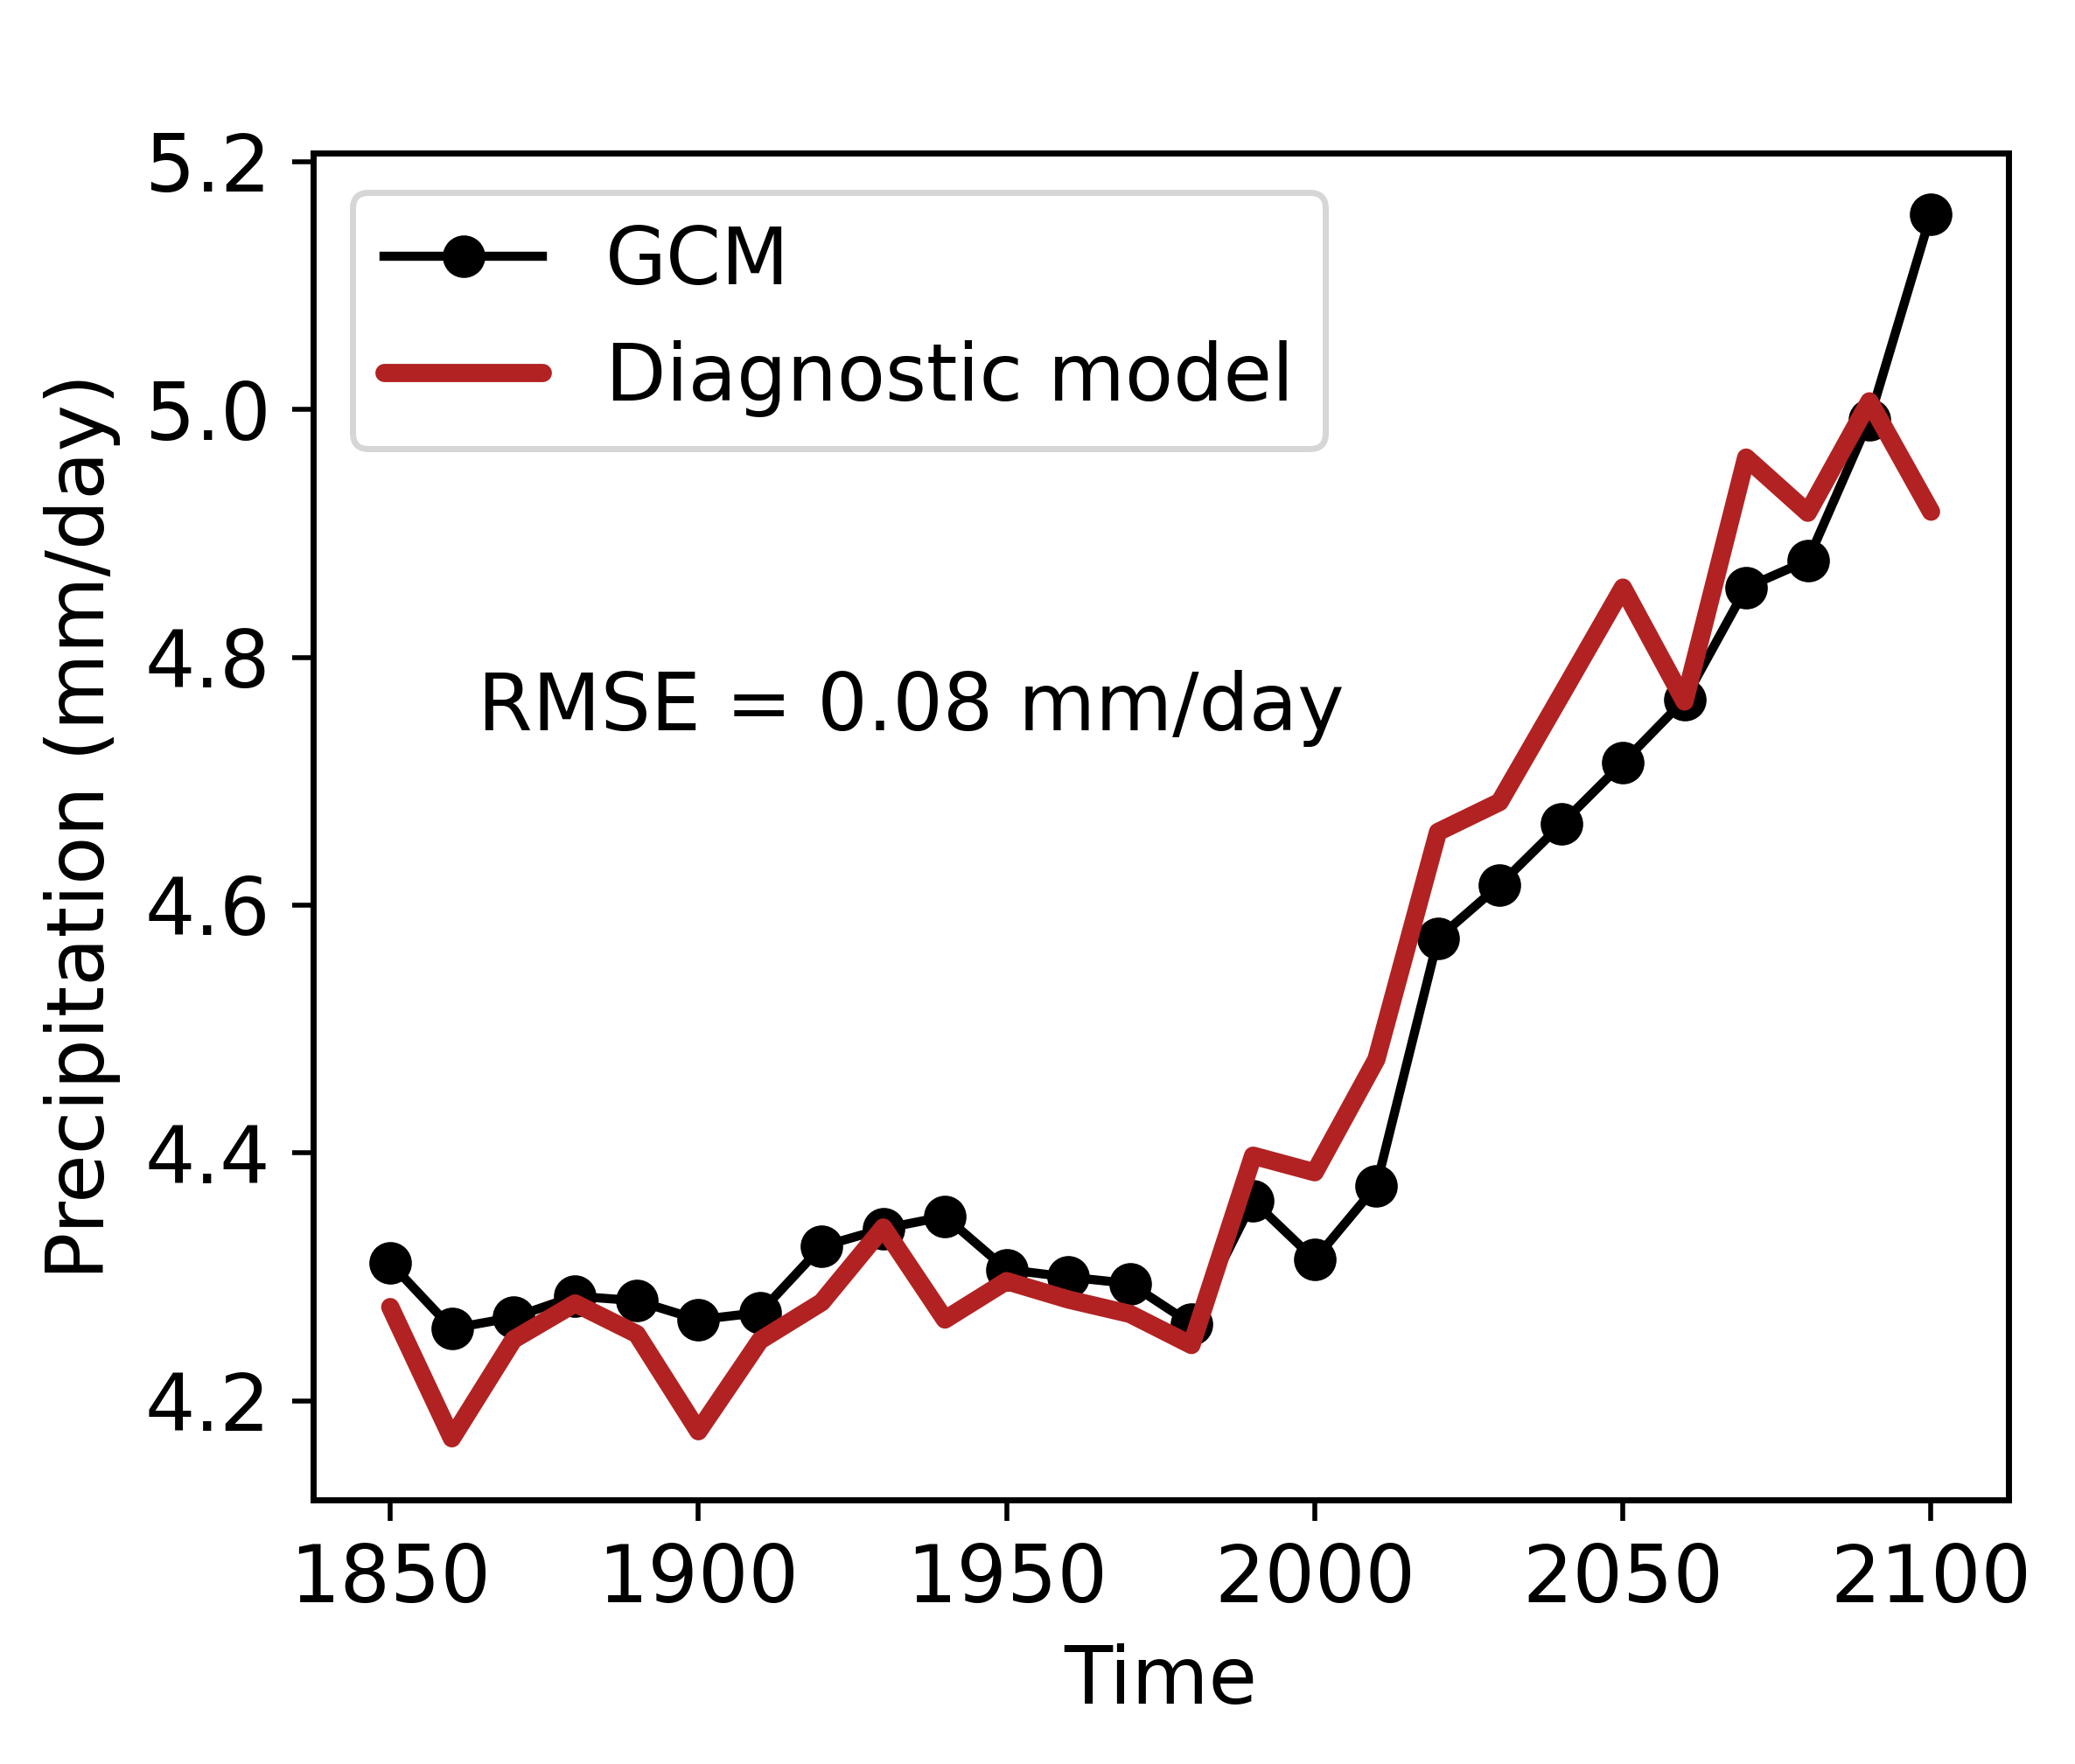

In [10]:
plt.rcParams.update({'font.size': 13})
plt.rcParams['figure.figsize'] = [5,4]
mpl.rcParams['axes.linewidth'] = 1
plt.plot(X1, Pr, c='black', label='GCM', marker='o')
plt.plot(X1, pred1, c='firebrick', label='Diagnostic model', lw=3, solid_capstyle='round')
plt.legend()
plt.ylabel('Precipitation (mm/day)')
plt.xlabel('Time')
plt.title(' ')
#plt.title('Model: INM-CM5-0')
plt.figtext(0.2, 0.55, 'RMSE = %.2f mm/day' %(rmse1))

Text(0.4, 0.6, 'RMSE = 0.26 mm/day')

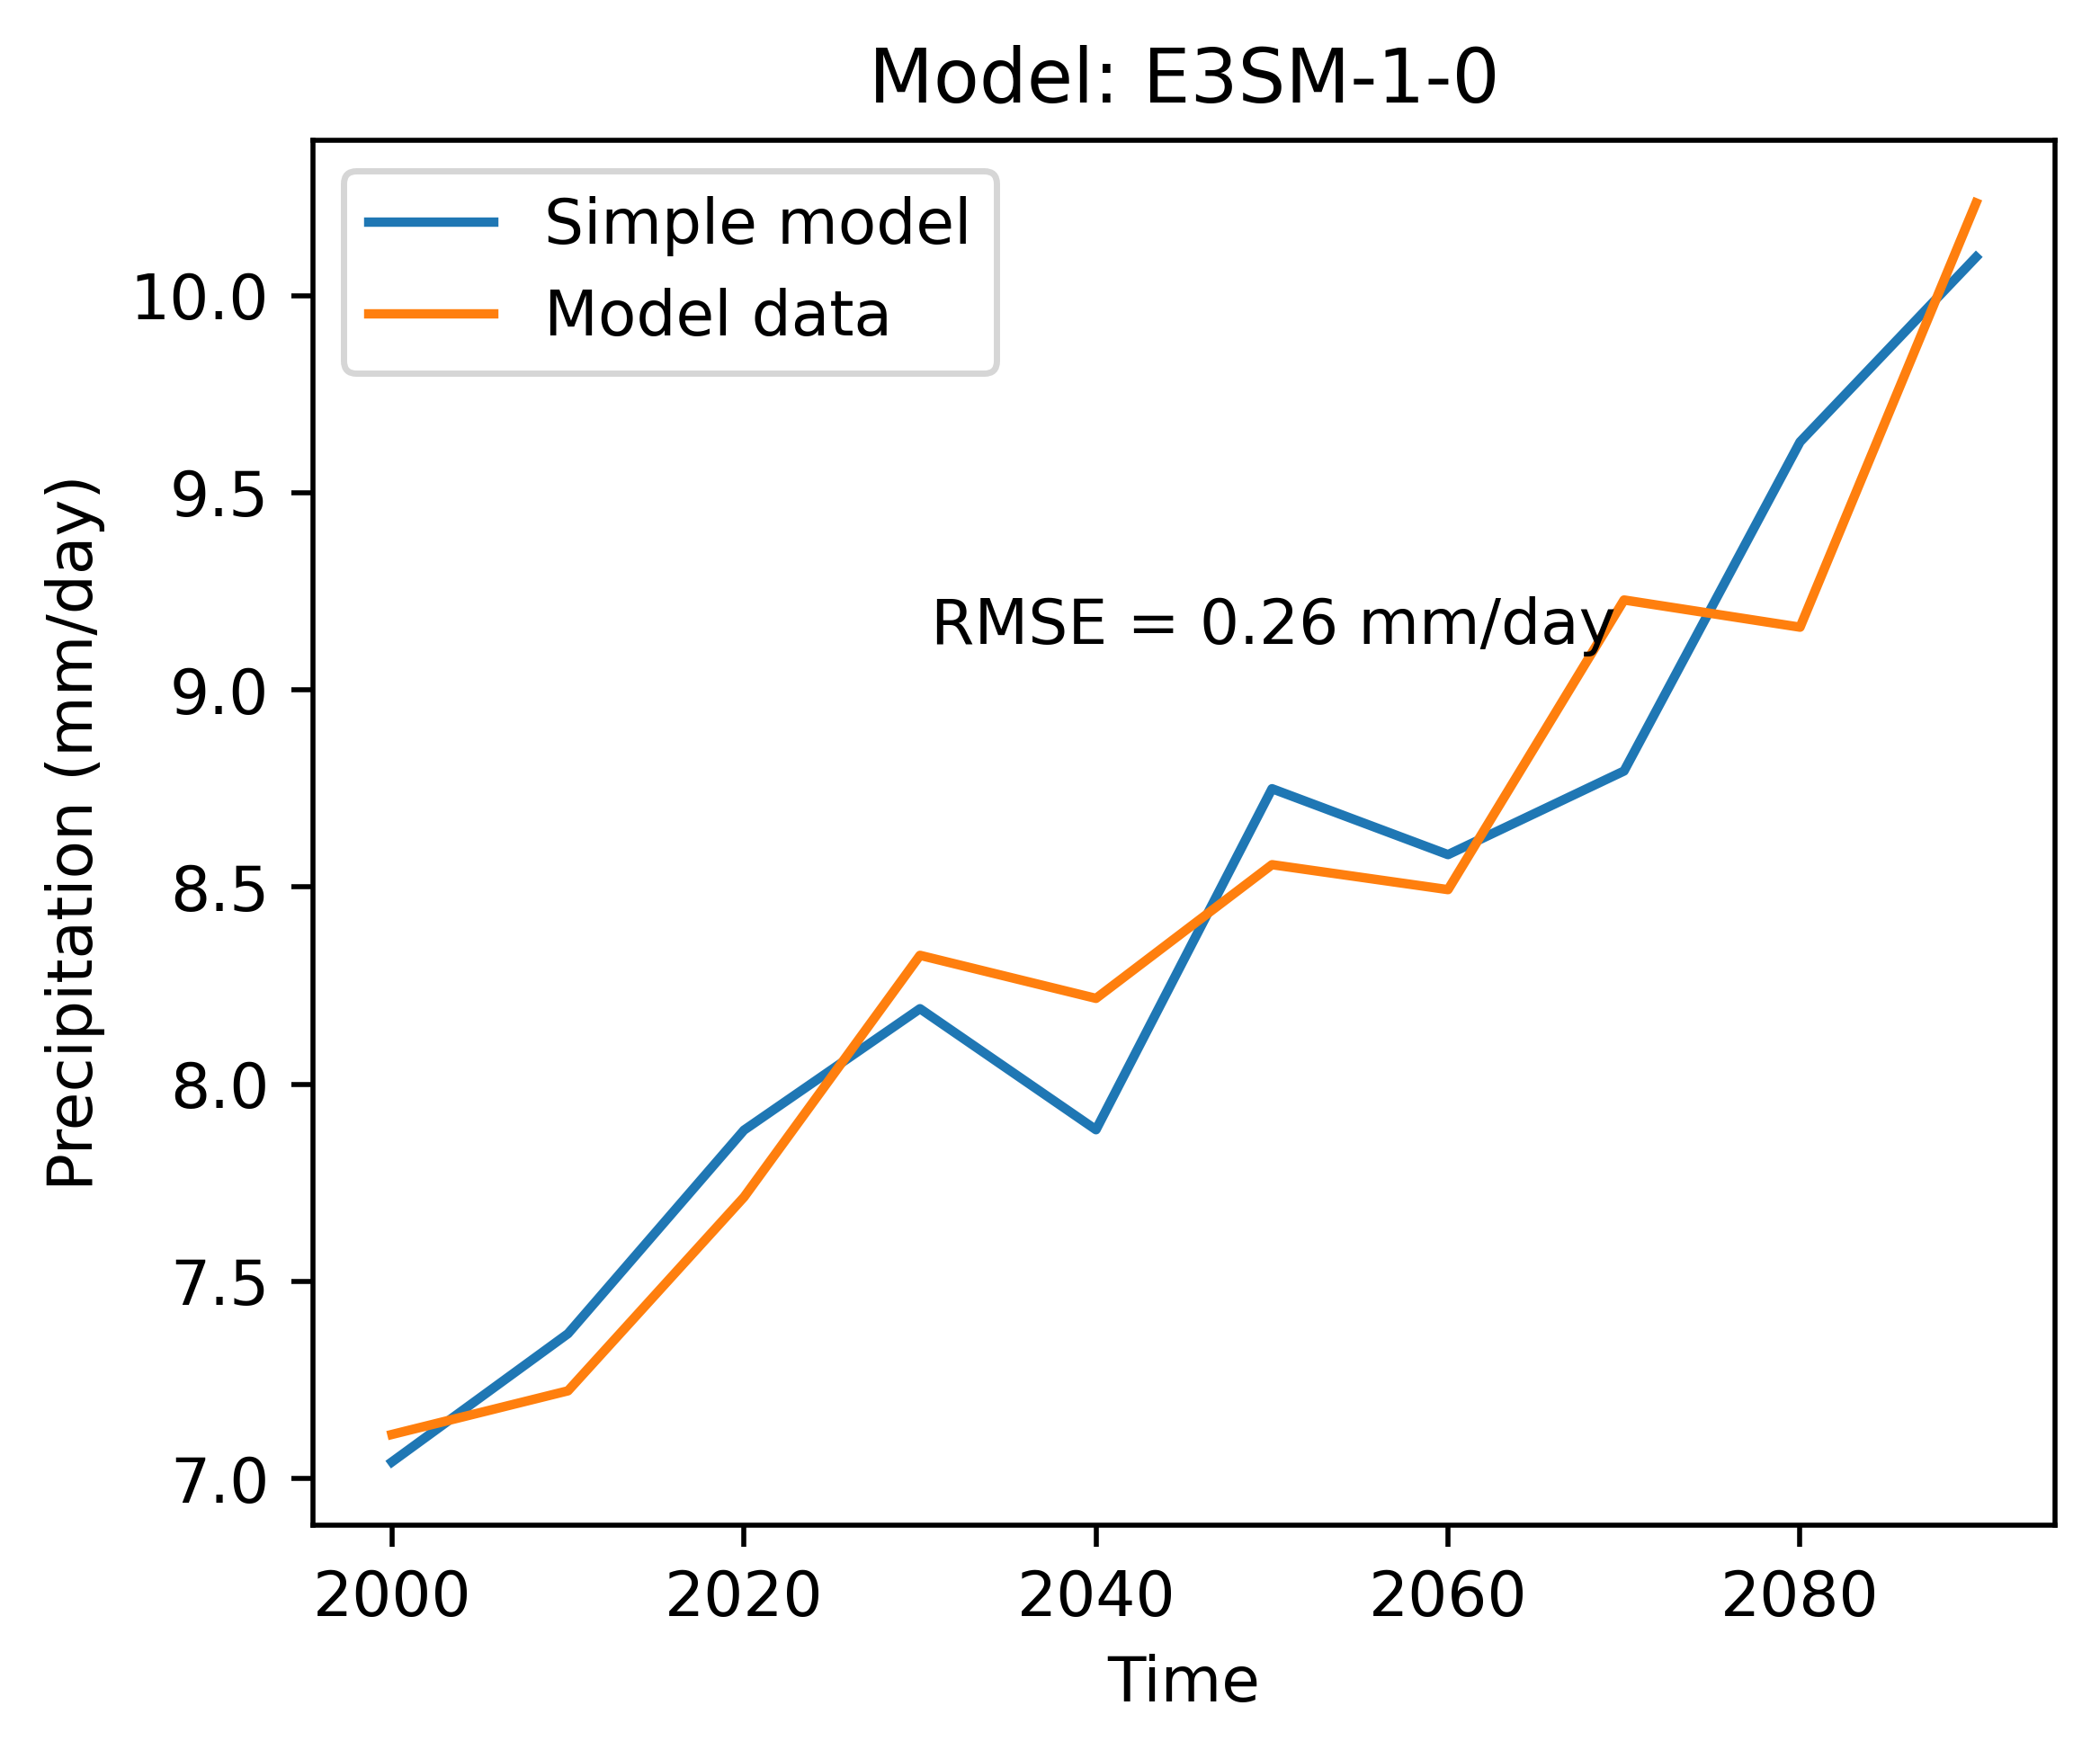

In [33]:
plt.plot(X1[15:25], pred1, label='Simple model')
plt.plot(X1[15:25], Pr[15:], label='Model data')
plt.legend()
plt.ylabel('Precipitation (mm/day)')
plt.xlabel('Time')
plt.title('Model: E3SM-1-0')
plt.figtext(0.4, 0.6, 'RMSE = %.2f mm/day' %(rmse1))

Text(0, 0.5, 'Rainfall from diagnostic model (mm/day)')

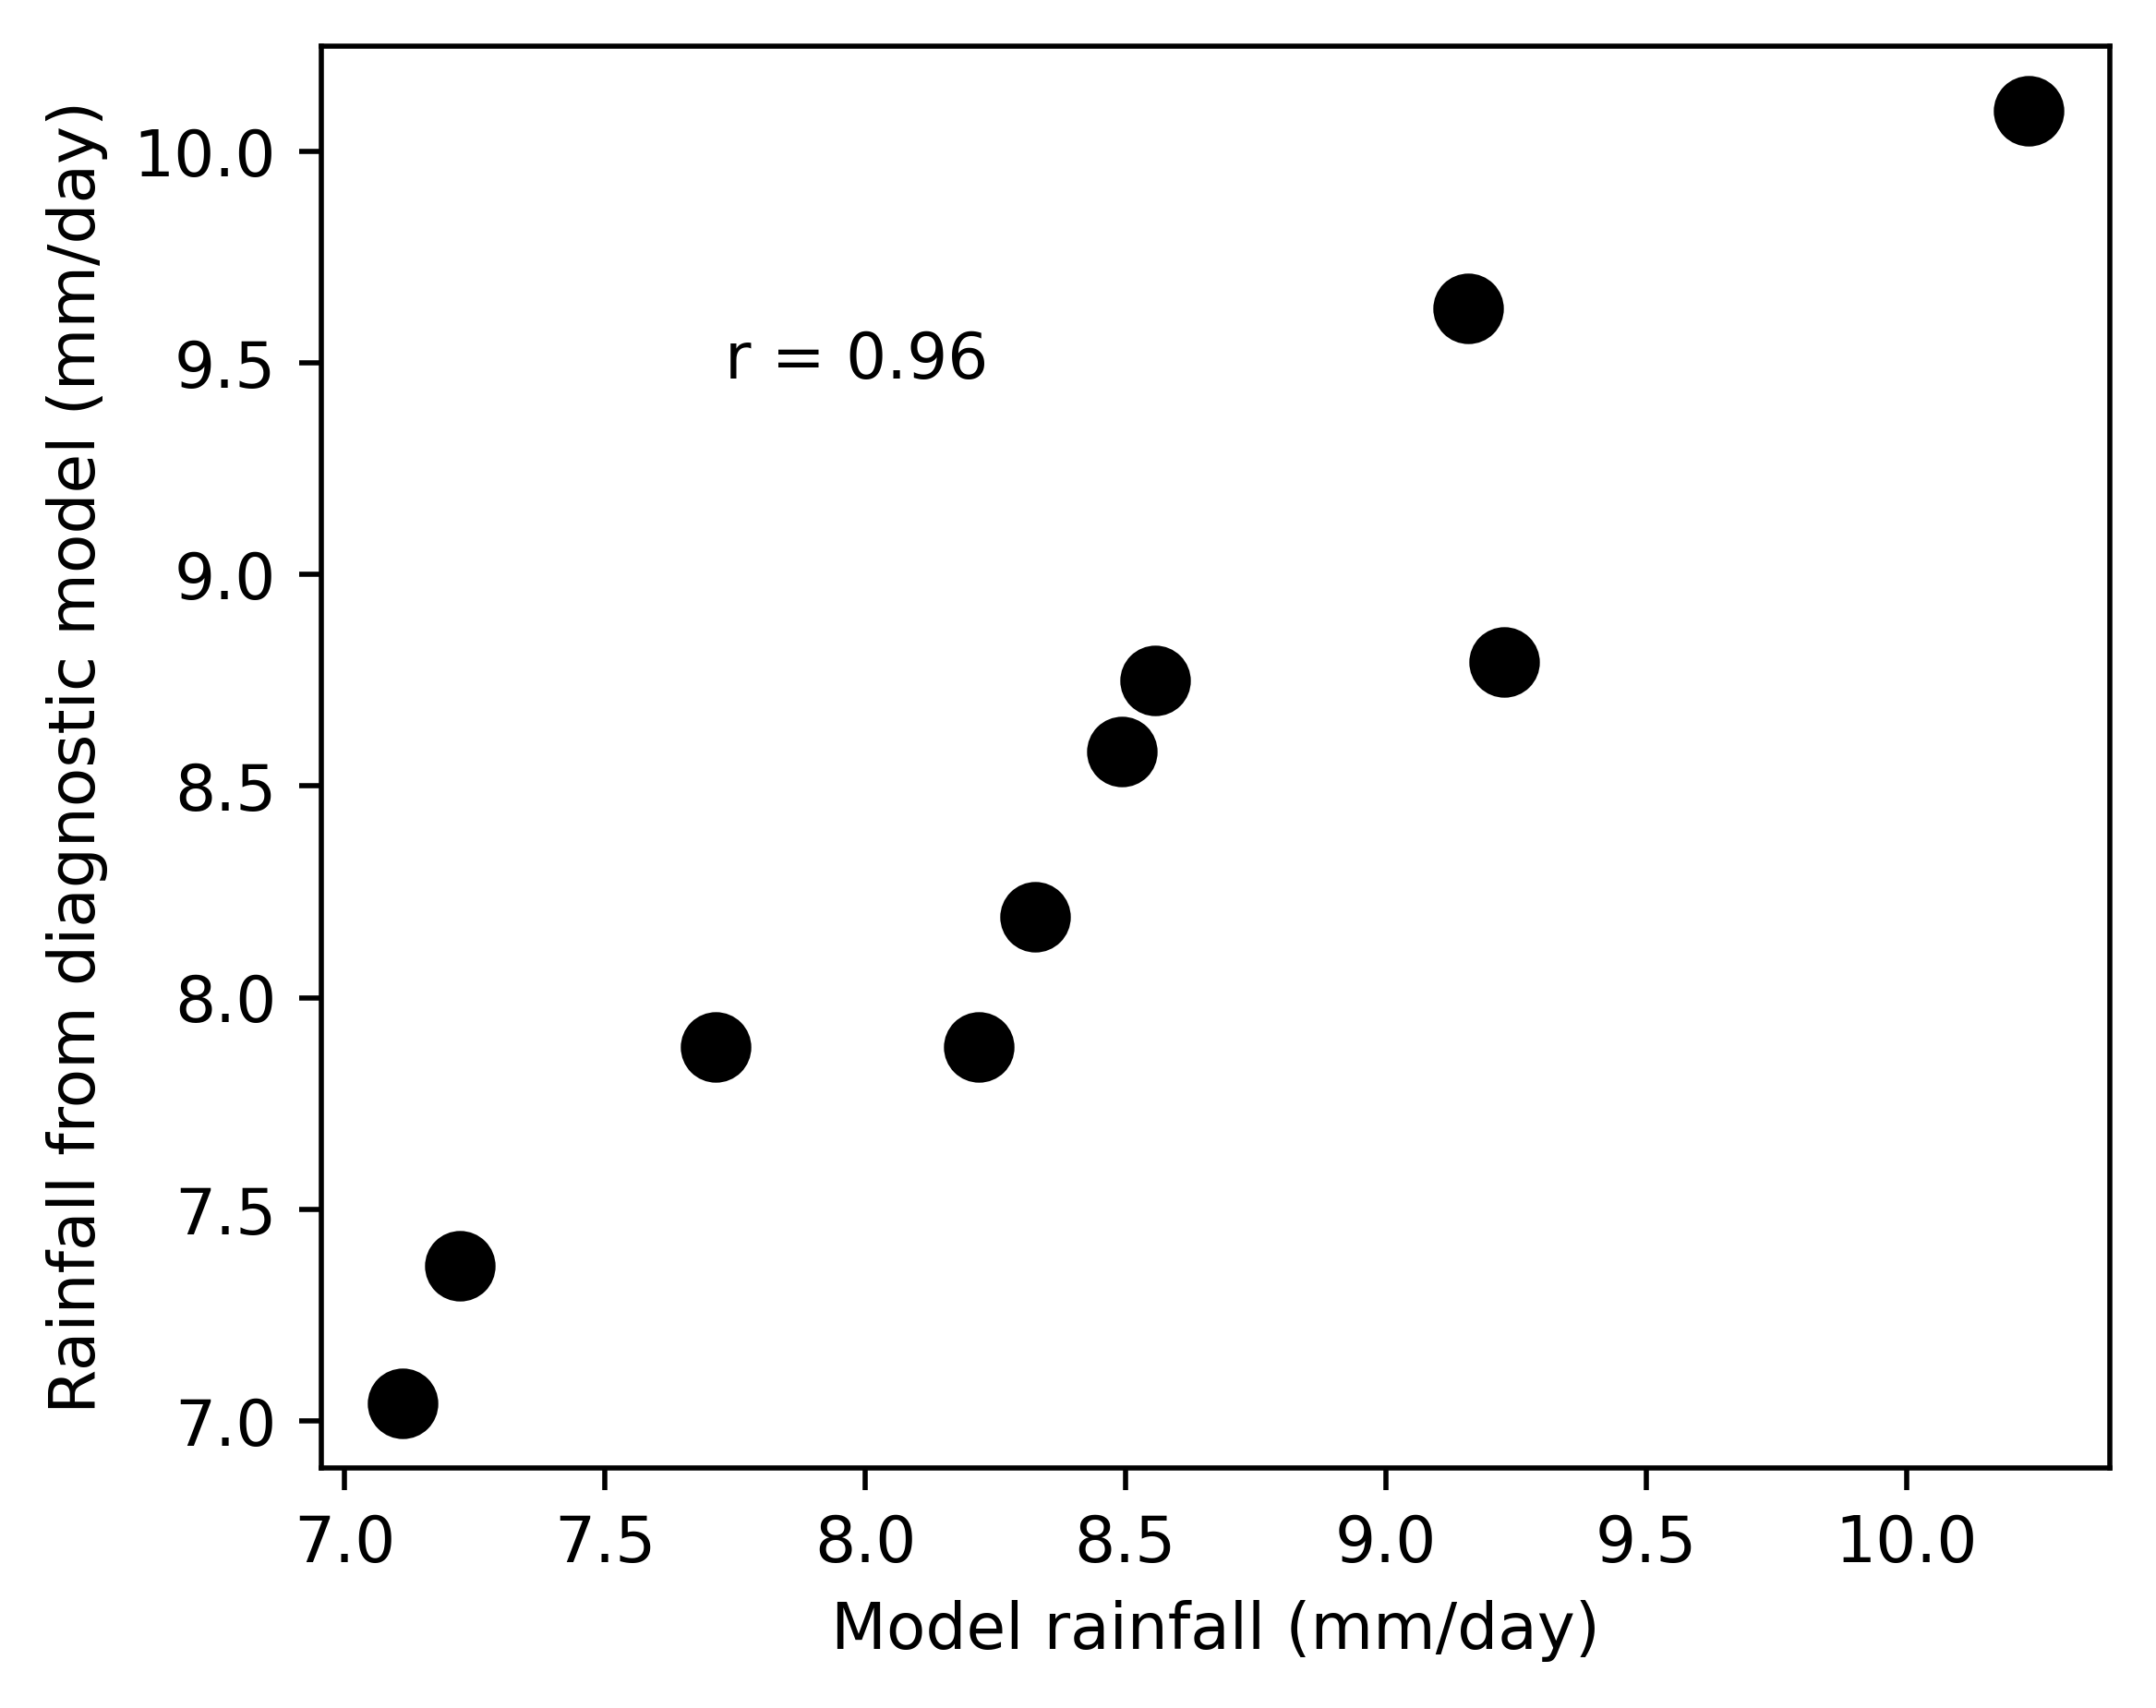

In [35]:
plt.scatter(Pr[15:25], pred1, s=100, c='black')
plt.figtext(0.3, 0.7, 'r = %0.2f'%(np.corrcoef(Pr[15:25], pred1)[0][1]))
plt.xlabel('Model rainfall (mm/day)')
plt.ylabel('Rainfall from diagnostic model (mm/day)')

In [20]:
def pred(e,qnet,pwat,c, b, g):
    return (e + qnet * pwat/((c-b*g)-pwat))/28.96

In [32]:
pred(85, 58, 40, 348, 42932, 0.0069)

9.741874943550561

In [12]:
E.values

array([88.494   , 85.16337 , 87.244286, 85.07229 , 86.13541 , 85.653336,
       83.71341 , 83.24735 , 83.76347 , 82.68556 , 85.92874 , 83.5287  ,
       85.85806 , 79.875694, 81.46644 , 81.593864, 80.9569  , 85.689964,
       85.13365 , 86.521545, 87.90503 , 89.35178 , 87.24157 , 90.295   ,
       94.20542 ], dtype=float32)

In [13]:
Qdiv.values

array([58.91986 , 58.18962 , 59.4682  , 58.65207 , 58.603577, 60.21022 ,
       57.998886, 60.329666, 59.4449  , 57.747482, 58.745407, 58.05641 ,
       58.51793 , 57.84822 , 58.61975 , 55.46057 , 56.935104, 57.55568 ,
       55.751785, 54.78682 , 56.573044, 57.08995 , 57.009445, 59.40976 ,
       59.555145], dtype=float32)

In [14]:
Pwat.values

array([40.797592, 40.22725 , 40.846375, 40.0364  , 40.556725, 40.07209 ,
       38.74728 , 39.072884, 40.431026, 39.92807 , 40.8492  , 39.712315,
       40.34006 , 39.700634, 41.247643, 43.59171 , 45.368797, 47.733562,
       50.628193, 52.025196, 55.462482, 57.339836, 60.75565 , 65.20503 ,
       69.97789 ], dtype=float32)

In [15]:
const2

array([63.35320262, 64.87940356, 66.99863418, 69.18755187, 72.12523915,
       74.42465705, 77.90454082, 81.44229303, 85.74999772, 91.003676  ])

# Contribution for CMCC

In [98]:
Pwat = np.array([45.431896, 46.51542 , 46.29129 , 45.94341 , 45.816933, 46.989326,
       47.798367, 47.704525, 48.64637 , 46.905838, 48.04038 , 48.334396,
       49.08826 , 49.24232 , 49.454567, 52.16668 , 52.77088 , 52.465946,
       56.246128, 58.063892, 60.206173, 62.999535, 65.29105 , 67.73926 ,
       69.77204 , 72.19862 ])

In [99]:
Pr = np.array([6.32024584, 7.18520922, 6.77385621, 7.05437106, 6.81804225,
       7.41475874, 7.67615782, 7.2390839 , 7.7341608 , 7.02068838,
       7.52371824, 7.46292472, 7.78371231, 7.27524091, 7.36451636,
       7.97523397, 7.58148863, 6.78929631, 8.18087496, 8.36727885,
       8.50451596, 8.81076932, 9.02199077, 9.40212475, 9.68582116,
       9.82207004])

In [100]:
#for CMCC
gammalist = [-0.006603245,
 -0.006599083,
 -0.0065960977,
 -0.0066038403,
 -0.0066116424,
 -0.0065933405,
 -0.0065803155,
 -0.0065750983,
 -0.006560706,
 -0.0065873074,
 -0.00656016,
 -0.0065628802,
 -0.006537746,
 -0.0065112878,
 -0.0065108794,
 -0.006469703,
 -0.006423036,
 -0.0064056376,
 -0.006349389,
 -0.006306395,
 -0.0062555033,
 -0.0061852266,
 -0.006152857,
 -0.006106478,
 -0.0060531185,
 -0.0060054637]

lambdalist = [0.26249778,
 0.2610857,
 0.26162052,
 0.26095656,
 0.26133952,
 0.26101527,
 0.2617906,
 0.26248637,
 0.2617599,
 0.26238784,
 0.2627733,
 0.26271573,
 0.26347834,
 0.26488745,
 0.26456678,
 0.26651713,
 0.26755127,
 0.26983267,
 0.27173486,
 0.27472967,
 0.27699035,
 0.2818377,
 0.28356212,
 0.2874871,
 0.29198483,
 0.29661223]

gammalist = abs(np.array(gammalist))
lambdalist = np.divide(1, lambdalist)

# Contribution for E3SM

In [65]:
model2 = '/media/rakshith/Seagate Expansion Drive/Good models/INM-CM5-0/*.nc'
cmcc = xr.open_mfdataset(model2)

#model2 = '/media/rakshith/Seagate Expansion Drive/Good models/CMCC/*.nc'
#cmcc = xr.open_mfdataset(model2)

In [66]:
grid1 = cmcc.sel(lat=slice(10,30), lon=slice(70,90))
months = grid1.time.dt.month.isin(range(6, 10))
JJAS = grid1.sel(time=months) 

lon_grid1, lat_grid1 = np.meshgrid(grid1.lon, grid1.lat)
mask1 = globe.is_land(lat_grid1, lon_grid1)

clim=JJAS.resample(time="10AS").mean()

In [67]:
Pwat = clim.prw.where(mask1>0).mean(dim=['lat', 'lon'])
P = 86400*28.96*((clim.pr.where(mask1>0).mean(dim=['lat', 'lon'])-clim.evspsbl.where(mask1>0).mean(dim=['lat', 'lon'])))
Qdiv = clim.rsdt.where(mask1>0).mean(dim=['lat', 'lon']) - clim.rsut.where(mask1>0).mean(dim=['lat', 'lon']) - clim.rlut.where(mask1>0).mean(dim=['lat', 'lon'])
E = 86400*28.96*(clim.evspsbl.where(mask1>0).mean(dim=['lat', 'lon']))
Pr = 86400*(clim.pr.where(mask1>0).mean(dim=['lat', 'lon']))

In [68]:
#INM const predicted from gamma
const = np.array([60.86338034, 60.75756422, 60.58378672, 60.21881522, 59.94610629,
       61.76866705, 60.61069456, 61.62053557, 61.73266633, 62.51760383,
       61.53554508, 62.07939119, 62.2561849 , 61.20729377, 62.20296692,
       62.45920573, 63.26053586, 64.06773238, 65.48742265, 67.03348347,
       67.77680292, 70.13229058, 70.44863206, 72.17168583, 73.41411751,
       75.35066303])

In [19]:
const = np.array([64.26608863, 64.4447732 , 64.57293923, 64.24053099, 63.90556826,
       64.69131239, 65.25050664, 65.47449345, 66.09238914, 64.95032773,
       66.11583022, 65.99904556, 67.07811659, 68.21403009, 68.23156367,
       69.99936452, 72.0028899 , 72.74984462, 75.16473089, 77.01056563,
       79.19546744, 82.21261343, 83.6023174 , 85.59347825, 87.88432858,
       89.93026256])

In [69]:
X = np.arange(1850, 2110, 10)

In [70]:
def pred(e,qnet,pwat,c):
    return e + qnet * pwat/(c-pwat)

pred2 = pred(E[15:21].values, Qdiv[15:21].values, Pwat[15].values, const[15:21])/28.96

In [71]:
pred1 = pred(E[15:21].values, Qdiv[15:21].values, Pwat[15:21].values, const[15:21])/28.96

In [72]:
pred3 = pred(E[15:21].values, Qdiv[15:21].values, Pwat[15:21].values, const[15])/28.96

In [73]:
dP = pred1 - pred1[0]

In [74]:
gdP = pred2 - pred1

In [75]:
pwatdP = pred3 - pred1

In [76]:
edP = E[15:21]/28.96 - E[15]/28.96

In [78]:
edP = np.array([0.        , 0.04703116, 0.09780359, 0.1155808 , 0.25661874,
       0.21100736])

In [52]:
#for CMCC
edP = np.array([ 0.        , -0.0647614 , -0.20666862,  0.02372885,  0.09812117,
        0.1945517 ])

<BarContainer object of 6 artists>

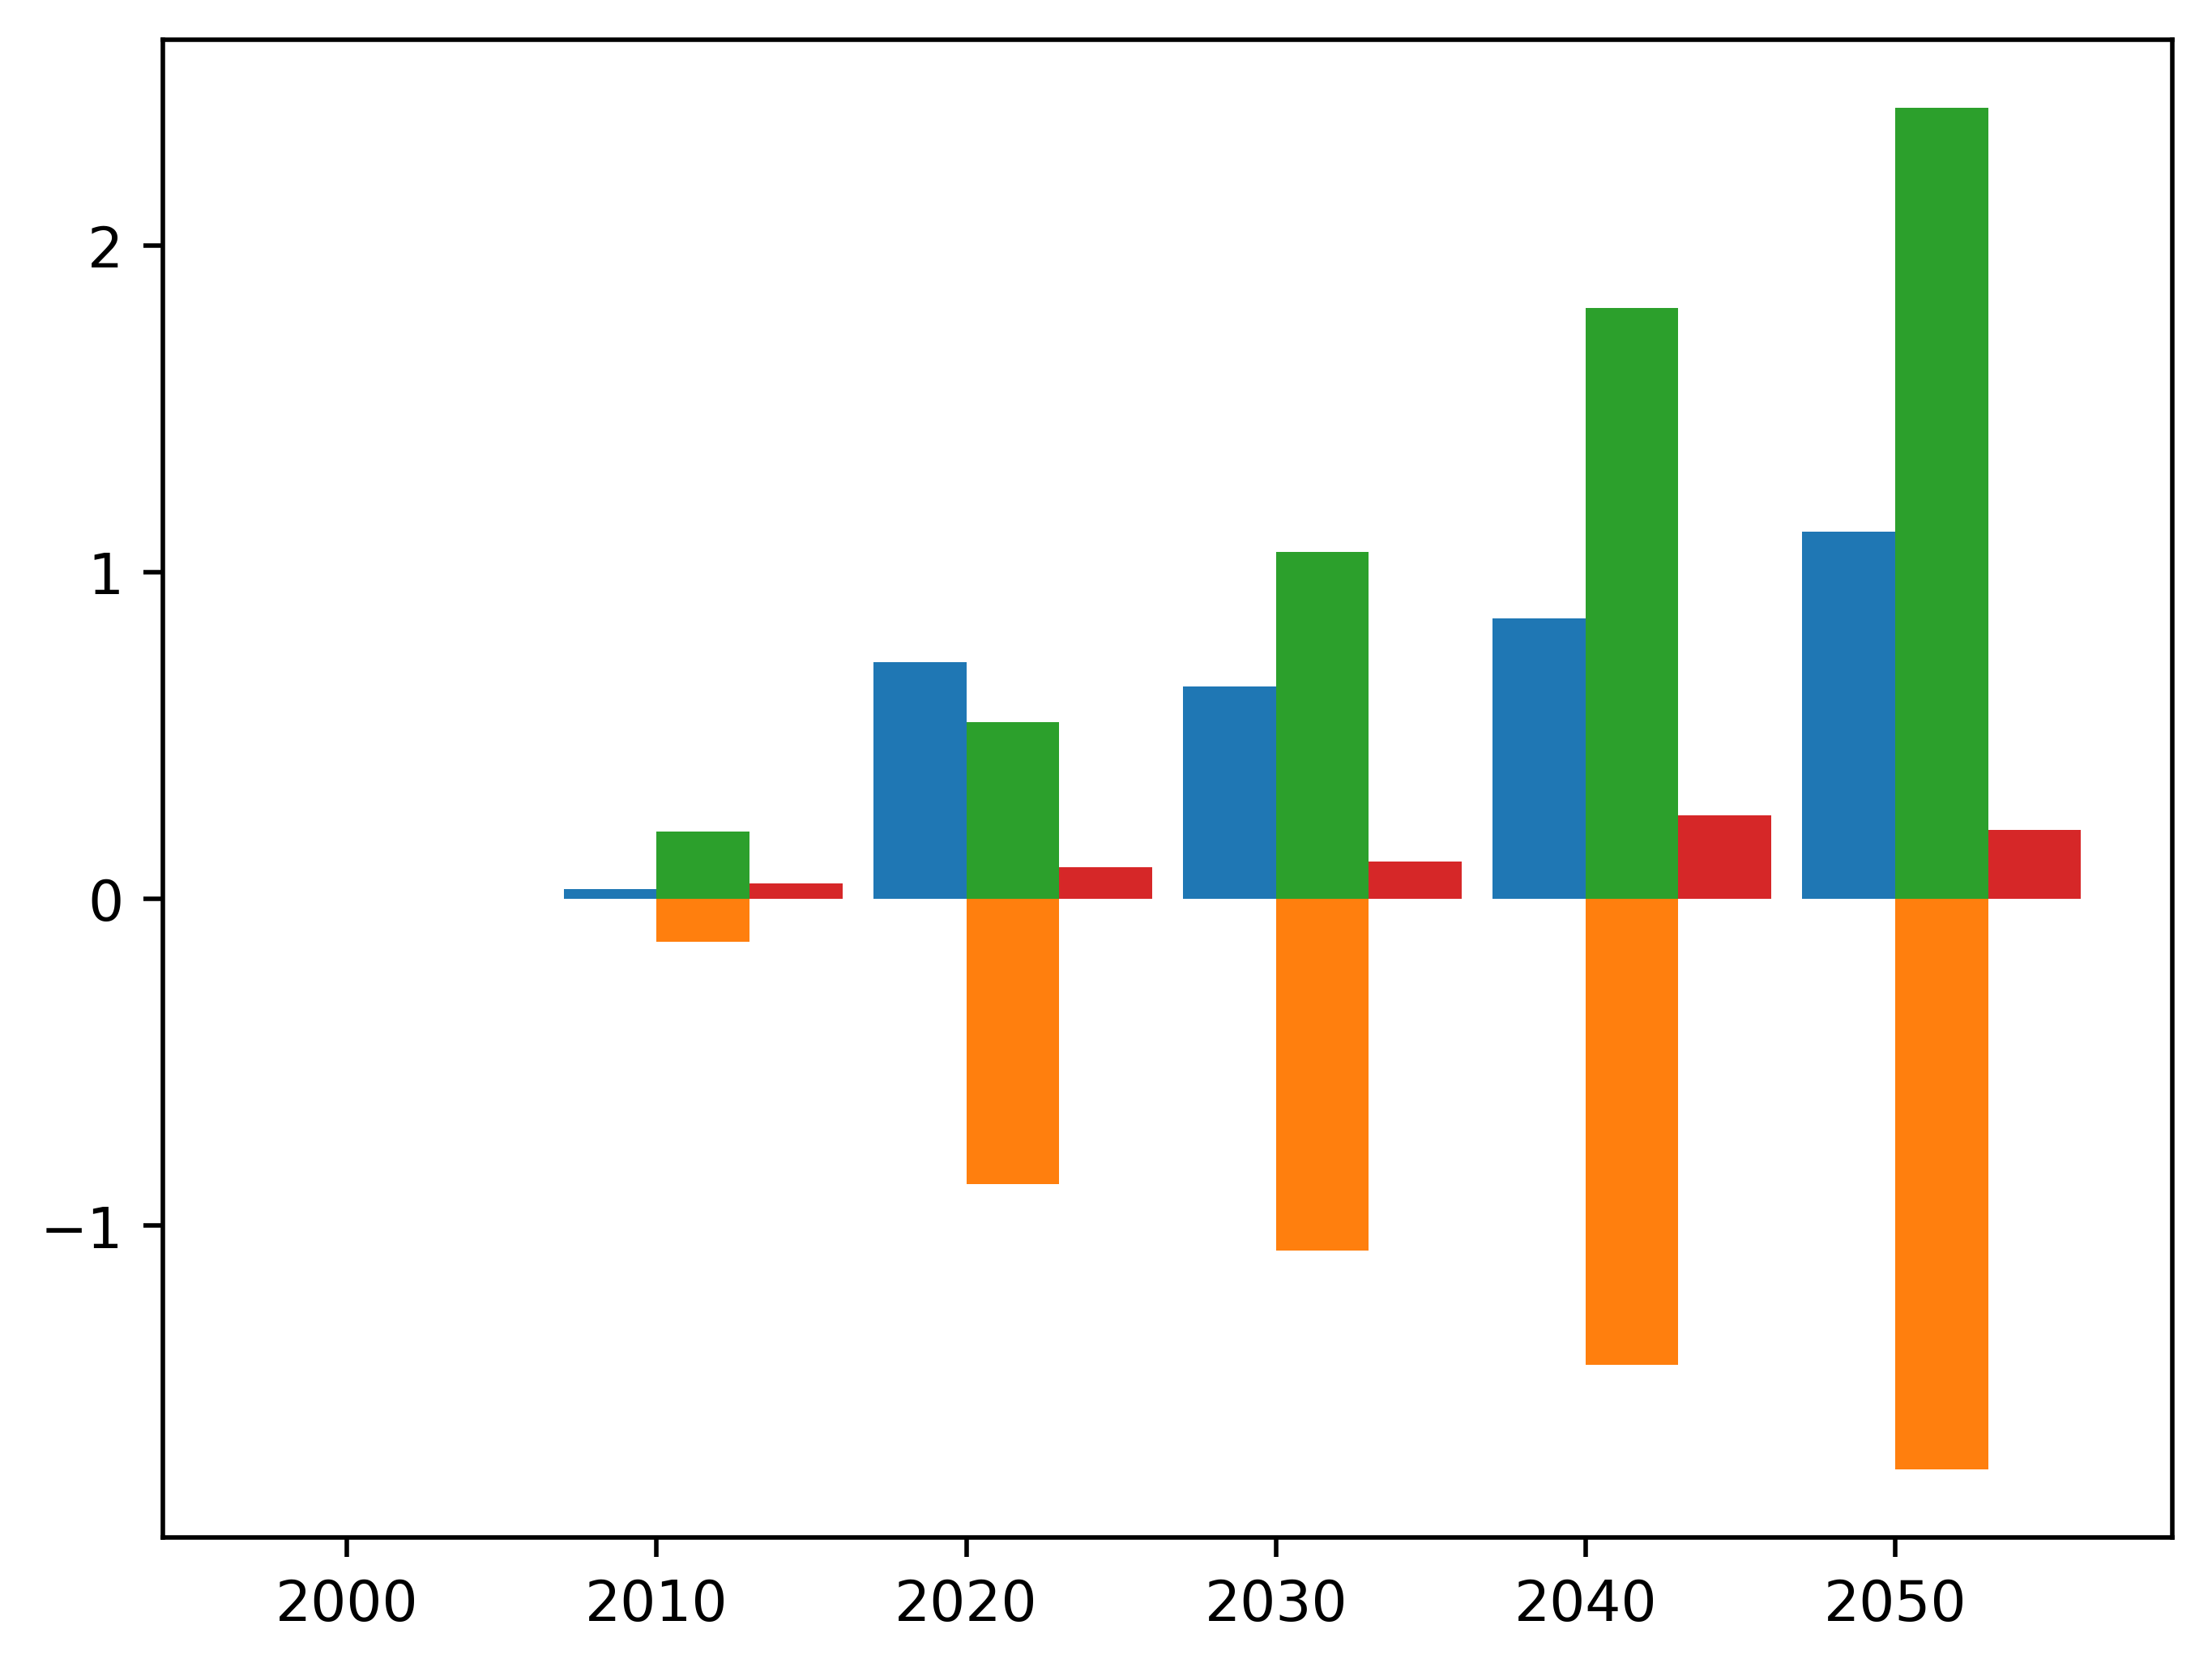

In [79]:
width = 3

plt.bar(X[15:21]-width/2, dP, width)
plt.bar(X[15:21]+width/2, gdP, width)
plt.bar(X[15:21]+width/2, pwatdP, width)
plt.bar(X[15:21]+1.5*width, edP, width)

In [51]:
dP

array([ 0.        , -0.52444024, -0.72688688,  0.38775055,  0.70469406,
        0.97823197])

In [80]:
pwatdP + edP +gdP

array([ 4.37833513e-07,  1.22577796e-01, -2.33084329e-01,  1.02692425e-01,
        6.40902781e-01,  8.85595024e-01])

<BarContainer object of 6 artists>

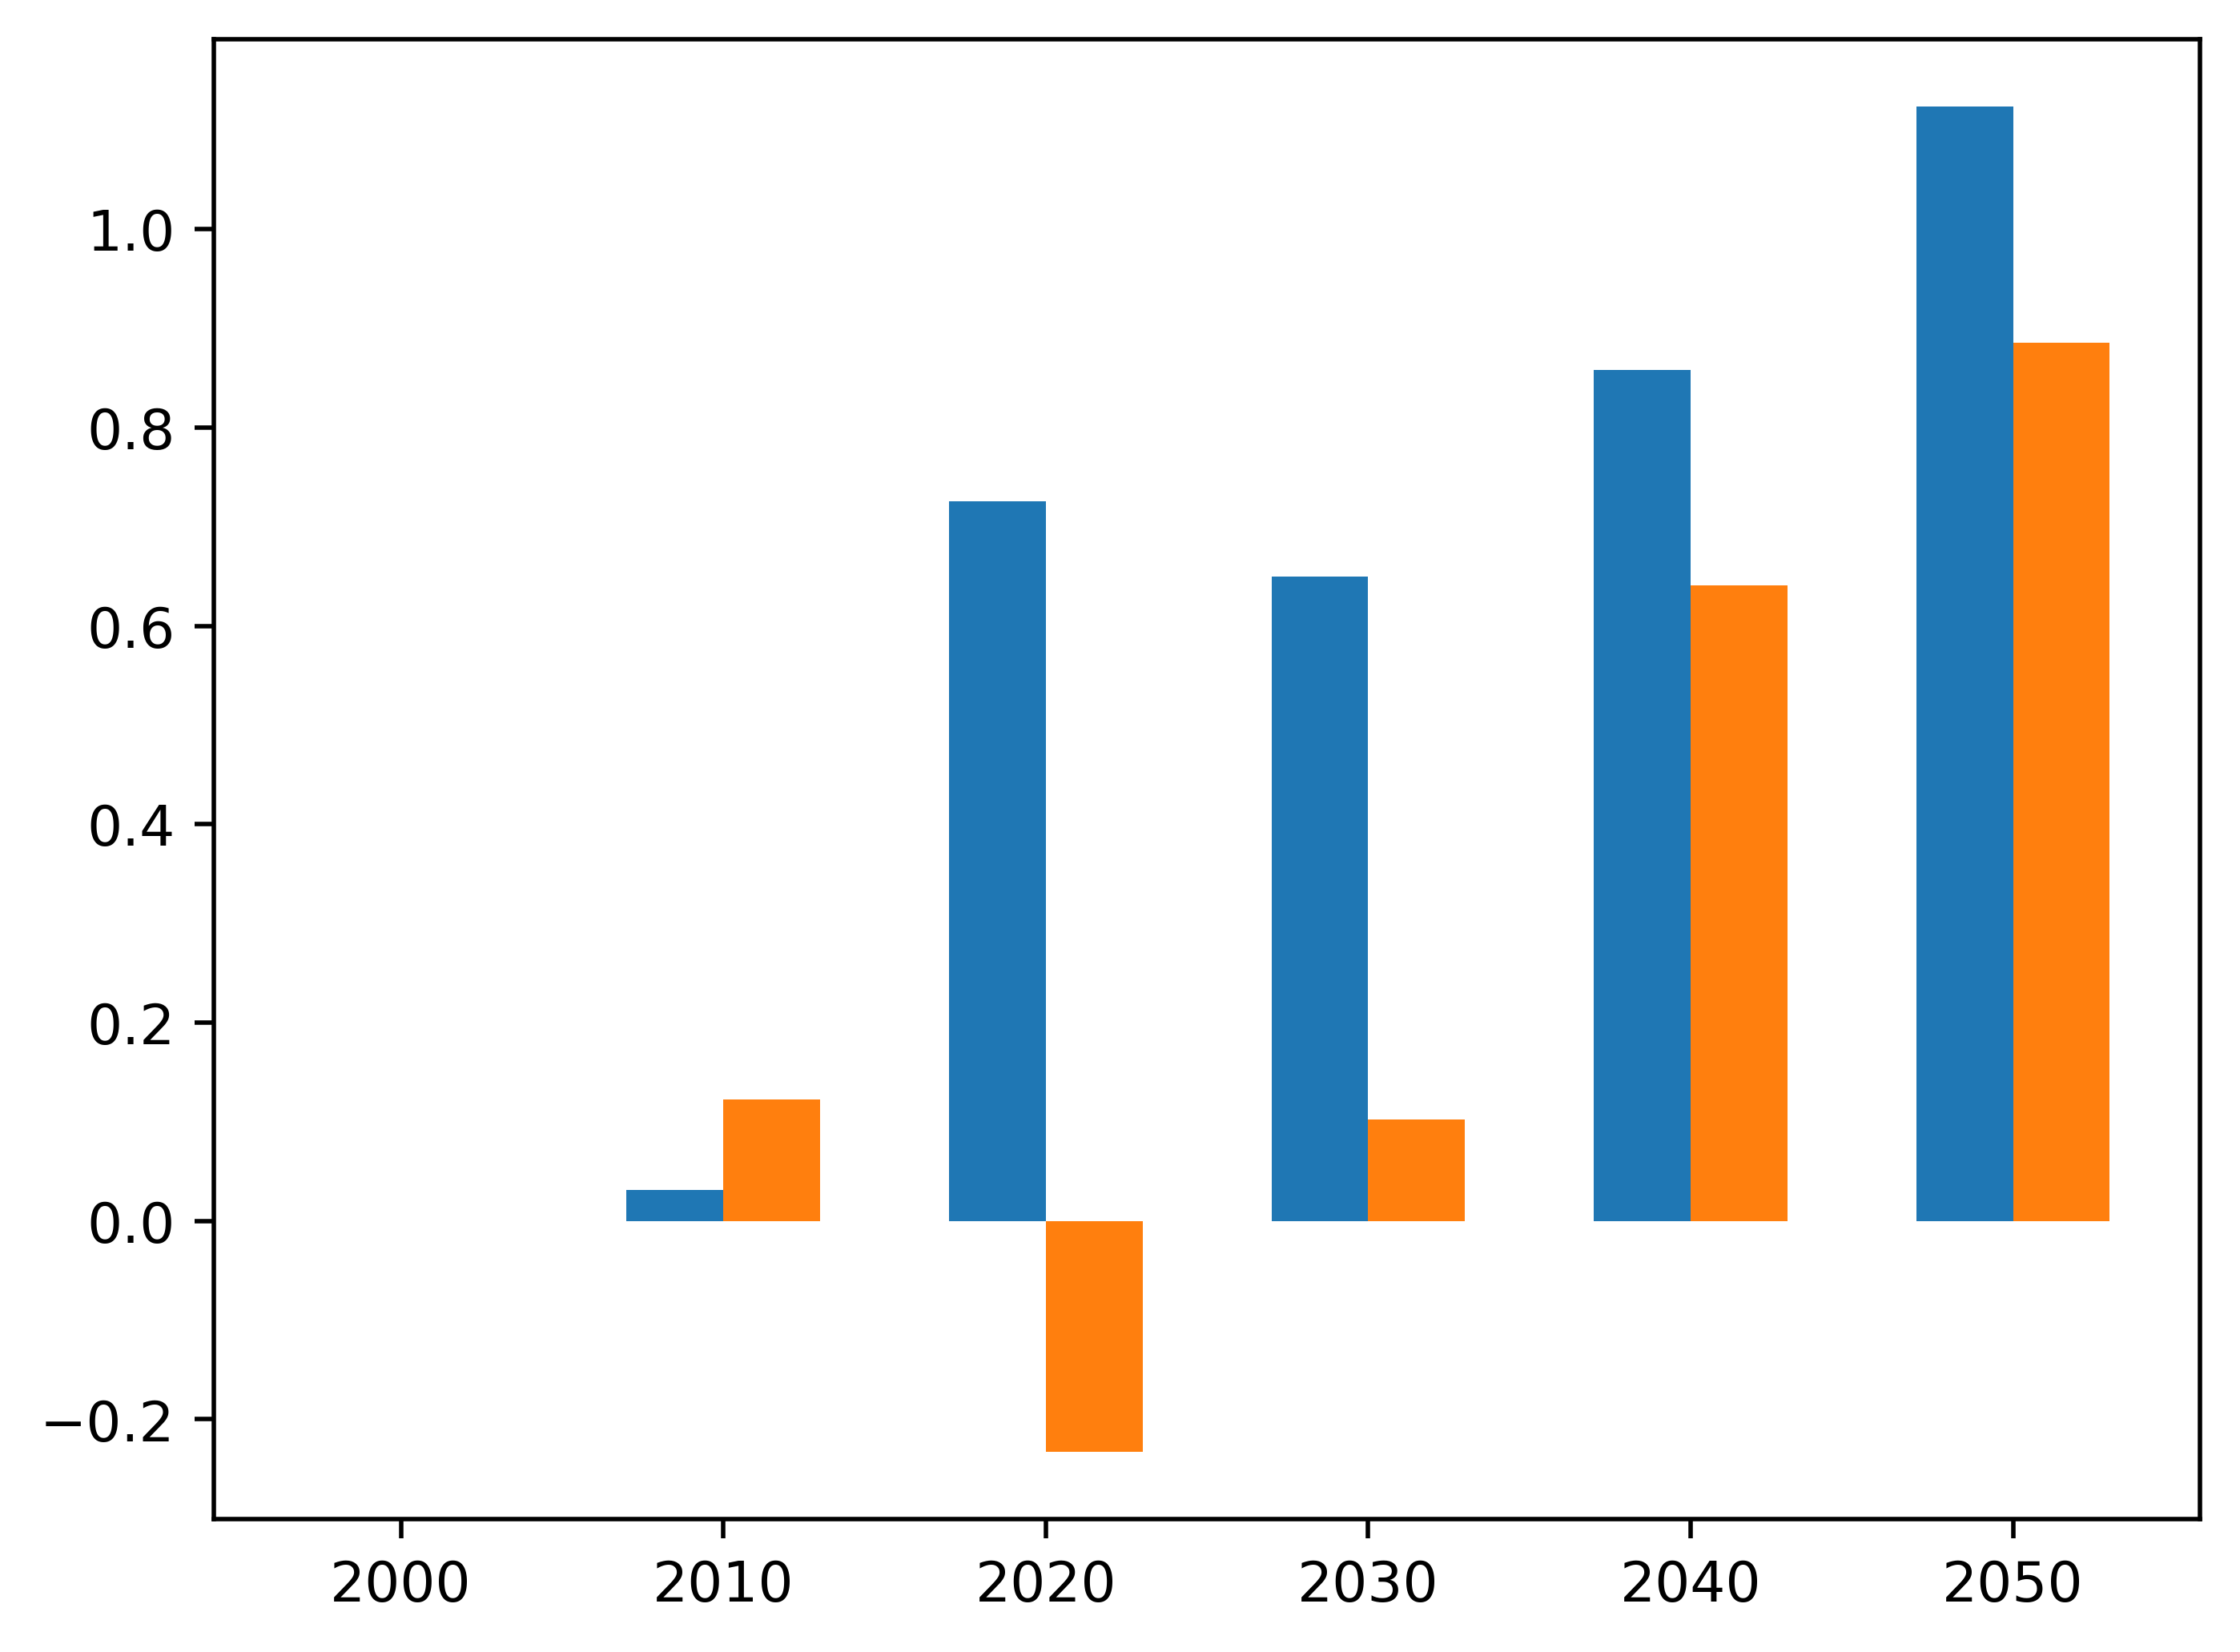

In [81]:
plt.bar(X[15:21]-width/2, dP, width)
plt.bar(X[15:21]+width/2, pwatdP + edP +gdP, width)